<center style="font-weight:bold;font-size:20px">wbenbihi/hourglasstensorlfow: Stacked Hourglass Network for Human Pose Estimation</center>

<center style="font-weight:bold;font-size:20px">Construct TF Dataset - Bounding Boxes</center>

# Setup

## Imports

In [1]:
import os
import sys
sys.path.append(os.path.join('..'))

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize
from utils import ROOT_PATH, load_configuration
sns.set()

## Global Variables

In [3]:
ROOT_FOLDER = ROOT_PATH
DATA_FOLDER = 'data'
IMAGE_FOLDER = 'images'
LABELS_FILE = "MPII_DATASET_LABELS.csv"

In [4]:
CFG = load_configuration(os.path.join(ROOT_PATH, 'config', 'hpeDefault.yml'))

# Function definition

## Numpy Functions

In [5]:
# define normalized 2D gaussian
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

def generate_joint_gaussian(img, x, y, sx=1, sy=1):
    if np.isnan(x) or np.isnan(y):
        return np.zeros_like(img[:, :, -1])
    y_space = np.linspace(0, img.shape[0], img.shape[0])
    x_space = np.linspace(0, img.shape[1], img.shape[1])
    x_space, y_space = np.meshgrid(x_space, y_space) # get 2D variables instead of 1D
    z = gaus2d(x_space, y_space, x, y, sx, sy)
    return z

## TensorFlow functions

In [6]:
# Image Reader
@tf.function
def tf_read_image(filename):
    image = tf.io.decode_jpeg(tf.io.read_file(filename), channels=3)
    return image

In [7]:
# Bivariate(2D) Gaussian
@tf.function
def tf_bivariate_normal_pdf(height, width, mx, my, sx, sy):
    X = tf.range(start=0., limit=tf.cast(width, tf.float32), delta=1.)
    Y = tf.range(start=0., limit=tf.cast(height, tf.float32), delta=1.)
    X, Y = tf.meshgrid(X, Y)
    R = tf.sqrt(((X-mx)**2/(sx**2)) + ((Y-my)**2)/(sy**2))
    Z = ((1. / (2 * np.pi) * tf.sqrt(sx*sy)) * tf.exp(-.5*R**2))
    return Z

In [ ]:
import math as m
# Bivariate(2D) Gaussian
@tf.function
def tf_bivariate_normal_pdf2(mx, my, height, width, sx, sy):
    X = tf.range(start=0.0, limit=tf.cast(width, tf.float64), delta=1.0, dtype=tf.float64)
    Y = tf.range(start=0.0, limit=tf.cast(height, tf.float64), delta=1.0, dtype=tf.float64)
    X, Y = tf.meshgrid(X, Y)
    print(X.dtype)
    print(Y.dtype)
    R = tf.cast(tf.sqrt(((X - mx) ** 2 / (sx ** 2)) + ((Y - my) ** 2) / (sy ** 2)), dtype=tf.float64)
    print(R.dtype)
    Z = (1.0 / (tf.constant(2.0*m.pi, dtype=tf.float64) * tf.cast(tf.sqrt(sx * sy), dtype=tf.float64))) * tf.exp(-0.5 * R ** 2)
    print(Z.dtype)
    return Z

In [8]:
# Single Heatmap generation
@tf.function
def tf_generate_heatmap(coord, image):
    shape = tf.shape(image, out_type=tf.dtypes.int32)
    height = shape[0]
    width = shape[1]
    if tf.reduce_all(tf.math.is_finite(coord)):
        x = coord[0] 
        y = coord[1]
        return tf_bivariate_normal_pdf(height, width, x, y, sx=10., sy=10.)
    else:
        return tf.zeros([height, width])

# Heatmaps generation iterator
@tf.function
def tf_heatmaps(coords, image):
    return tf.transpose(tf.map_fn(lambda x: tf_generate_heatmap(x, image), tf.cast(coords, tf.float32)), [1, 2, 0])

In [9]:
@tf.function
def tf_parse_dataset(filename, coords):
    images = tf_read_image(filename)
    heatmaps = tf_heatmaps(coords, images)
    return images, heatmaps

In [10]:
@tf.function
def tf_autopad(tensor):
    shape = tf.shape(tensor,out_type=tf.dtypes.int32)
    pad_x = tf.clip_by_value(
        shape[1] - shape[0],
        0,
        10000,
        name=None
    )
    pad_y = tf.clip_by_value(
        shape[0] - shape[1],
        0,
        10000,
        name=None
    )
    padded_tensor = tf.pad(
        tensor,
        [
            [pad_x // 2, pad_x //2],
            [pad_y // 2, pad_y //2],
            [0, 0],
        ]
    )
    return padded_tensor

@tf.function
def tf_resize(tensor, size):
    return tf.image.resize(tensor, [size, size])

@tf.function
def tf_resize_input(tensor):
    return tf.image.resize(tensor, [CFG.data.input_size, CFG.data.input_size])

@tf.function
def tf_resize_output(tensor):
    return tf.image.resize(tensor, [CFG.data.output_size, CFG.data.output_size])
    
@tf.function
def tf_preprocess(images, heatmaps):
    images = tf_autopad(images)
    heatmaps = tf_autopad(heatmaps)
    images = tf_resize(images, CFG.data.input_size)
    heatmaps = tf_resize(heatmaps, CFG.data.output_size)
    return images, heatmaps

In [11]:
@tf.function
def tf_load_images(filenames, coords):
    images = tf_read_image(filenames)
    return images, coords


In [12]:
@tf.function
def tf_get_bbox_coordinates(coords):
    # Get Min-Max X/Y
    xs = coords[:, 0]
    ys = coords[:, 1]
    maxx, minx = tf.reduce_max(xs), tf.reduce_min(xs)
    maxy, miny = tf.reduce_max(ys), tf.reduce_min(ys)
    
    return minx, maxx, miny, maxy

In [13]:
@tf.function
def tf_increase_bbox_area(bbox, img_shape, bbox_factor=0.5):
    # Unpack coordinates
    minx, maxx, miny, maxy = bbox[0], bbox[1], bbox[2], bbox[3]
    # Compute Bbow Width-Height
    width, height = maxx-minx, maxy-miny
    minx = tf.math.maximum(tf.constant(0., dtype=tf.float64), minx-width*bbox_factor)
    miny = tf.math.maximum(tf.constant(0., dtype=tf.float64), miny-height*bbox_factor)
    maxx = tf.math.minimum(tf.cast(img_shape[1], dtype=tf.float64), maxx+width*bbox_factor)
    maxy = tf.math.minimum(tf.cast(img_shape[0], dtype=tf.float64), maxy+height*bbox_factor)
    
    return minx, maxx, miny, maxy

In [14]:
@tf.function
def tf_compute_padding(bbox):
    # Unpack coordinates
    minx, maxx, miny, maxy = bbox[0], bbox[1], bbox[2], bbox[3]
    # Compute Bbow Width-Height
    width, height = maxx-minx, maxy-miny
    
    # Compute Padding
    height_padding = tf.math.maximum(tf.constant(0, dtype=tf.int64), width-height)
    width_padding = tf.math.maximum(tf.constant(0, dtype=tf.int64), height-width)
    padding = [[height_padding//2, height_padding//2], [width_padding//2, width_padding//2], [0,0]]
    
    return padding

In [15]:
@tf.function
def tf_compute_coordinates(images, coords, bbox_factor, resize_output=None):
    # Get Image Shape
    img_shape = tf.shape(images, out_type=tf.dtypes.int64)
    # Get Person Bbox
    minx, maxx, miny, maxy = tf_get_bbox_coordinates(coords)
    # Augment Bbox
    minx, maxx, miny, maxy = tf_increase_bbox_area(
        bbox=tf.stack([minx, maxx, miny, maxy]),
        img_shape=img_shape,
        bbox_factor=bbox_factor
    )
    # Compute Padding
    bbox=tf.cast(tf.stack([minx, maxx, miny, maxy]), dtype=tf.int64)
    padding = tf_compute_padding(bbox=bbox)
    minx, maxx, miny, maxy = bbox[0], bbox[1], bbox[2], bbox[3]
    # Crop Image
    cropped_image = images[miny:maxy, minx:maxx, :]
    padded_image = tf.pad(cropped_image, paddings=padding)
    # Recompute coordinates
    coords = coords - (tf.cast([minx, miny], dtype=tf.float64) - tf.cast([padding[1][0], padding[0][0]], dtype=tf.float64))
    if resize_output is not None:
        img_shape = tf.shape(padded_image, out_type=tf.dtypes.int64)
        coords= coords*tf.cast(resize_output, dtype=tf.float64) / tf.cast(tf.reduce_max(img_shape[:-1]), dtype=tf.float64)
    return padded_image, coords

## Viz functions

In [16]:
def aggregate_heatmaps(heatmaps):
    return heatmaps.sum(axis=0)

def plot_hVSimg(img, heatmaps, factor=1, figsize=(12, 7)):
    if len(heatmaps.shape) == 3:
        hm = aggregate_heatmaps(heatmaps)
    else:
        hm = heatmaps
    
    if len(img.shape) == 3:
        hm = np.expand_dims(hm, axis=-1)
    hm = hm / hm.max()
    
    plt.figure(figsize=figsize)
    plt.imshow(hm + img/(255.0*factor))
    plt.grid(b=None)

# Main Code

## Read Labels

In [17]:
mpii_dataset_df = pd.read_csv(os.path.join(ROOT_FOLDER, DATA_FOLDER, LABELS_FILE), sep=';')

In [18]:
mpii_dataset_df

,imgidx,image,frame_sec,vididx,is_train,ridx,x1,x2,y1,y2,...,joint_14_id,joint_14_is_visible,joint_15_x,joint_15_y,joint_15_id,joint_15_is_visible,video_list,cat_name,act_name,act_id
0,0,037454012.jpg,-1,-1,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
1,1,095071431.jpg,-1,-1,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,1,095071431.jpg,-1,-1,0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,2,073199394.jpg,-1,-1,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,3,059865848.jpg,-1,-1,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40934,24984,084761779.jpg,158,793,1,4,0.0,76.0,135.0,216.0,...,NaN,NaN,NaN,NaN,NaN,NaN,GqxDyQ_TfZc,transportation,pushing car,972
40935,24985,092025825.jpg,-1,-1,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
40936,24985,092025825.jpg,-1,-1,0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
40937,24986,053686627.jpg,-1,-1,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1


In [19]:
bbox_dataset_df = mpii_dataset_df.query('x1.notna() & x2.notna() & y1.notna() & y2.notna()')

## Explore samples

### Sanity checks

In [20]:
# Sanity Check - Look if every joint is in the roght columns
for i in range(16):
    print(f'Joint {i}\n',bbox_dataset_df[f'joint_{i}_id'].value_counts(), '\n')

Joint 0
 0.0    20773
Name: joint_0_id, dtype: int64 

Joint 1
 1.0    24330
Name: joint_1_id, dtype: int64 

Joint 2
 2.0    28212
Name: joint_2_id, dtype: int64 

Joint 3
 3.0    28218
Name: joint_3_id, dtype: int64 

Joint 4
 4.0    24344
Name: joint_4_id, dtype: int64 

Joint 5
 5.0    20772
Name: joint_5_id, dtype: int64 

Joint 6
 6.0    28100
Name: joint_6_id, dtype: int64 

Joint 7
 7.0    28674
Name: joint_7_id, dtype: int64 

Joint 8
 8.0    28674
Name: joint_8_id, dtype: int64 

Joint 9
 9.0    28673
Name: joint_9_id, dtype: int64 

Joint 10
 10.0    28563
Name: joint_10_id, dtype: int64 

Joint 11
 11.0    28665
Name: joint_11_id, dtype: int64 

Joint 12
 12.0    28776
Name: joint_12_id, dtype: int64 

Joint 13
 13.0    28768
Name: joint_13_id, dtype: int64 

Joint 14
 14.0    28653
Name: joint_14_id, dtype: int64 

Joint 15
 15.0    28500
Name: joint_15_id, dtype: int64 



In [21]:
# Check for images with no joint
bbox_dataset_df.query(" and ".join([f'(joint_{i}_id.isna())' for i in range(16)]))

,imgidx,image,frame_sec,vididx,is_train,ridx,x1,x2,y1,y2,...,joint_14_id,joint_14_is_visible,joint_15_x,joint_15_y,joint_15_id,joint_15_is_visible,video_list,cat_name,act_name,act_id
2191,1367,090903252.jpg,60,2655,1,0,1412.0,1527.0,0.0,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,wW1gyfLCEW4,winter activities,dog sledding,47
3477,2248,059897851.jpg,428,2280,1,1,1388.0,1610.0,124.0,376.0,...,NaN,NaN,NaN,NaN,NaN,NaN,oSPUMDPsz6k,occupation,"working in scene shop, theater actor, backstag...",103
5243,3174,007049195.jpg,63,1065,1,0,568.0,636.0,43.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Mrc0Y5x1UfU,sports,"rope skipping, general",378
7758,4916,032783820.jpg,41,2528,1,1,793.0,914.0,346.0,518.0,...,NaN,NaN,NaN,NaN,NaN,NaN,thvlhJya6qg,occupation,"hairstylist (e.g., plaiting hair, manicure, ma...",773
8826,5602,012525123.jpg,159,927,1,1,607.0,654.0,166.0,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,JvpNDW4LYUE,occupation,"carpentry, general",899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38482,23850,099879285.jpg,97,779,1,0,604.0,861.0,529.0,881.0,...,NaN,NaN,NaN,NaN,NaN,NaN,GWnRhyOGvqA,occupation,"hairstylist (e.g., plaiting hair, manicure, ma...",773
38484,23851,015883915.jpg,107,779,1,0,848.0,1085.0,557.0,863.0,...,NaN,NaN,NaN,NaN,NaN,NaN,GWnRhyOGvqA,occupation,"hairstylist (e.g., plaiting hair, manicure, ma...",773
38703,23957,062020483.jpg,144,6,1,2,39.0,63.0,174.0,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-2uisU2cXqQ,sports,"martial arts, different types",775
40587,24732,011387000.jpg,49,2718,1,0,1350.0,1721.0,501.0,875.0,...,NaN,NaN,NaN,NaN,NaN,NaN,xyFfCA34stw,sports,"high ropes course, multiple elements",809


In [22]:
# Check for images with full joint
bbox_dataset_df.query(" and ".join([f'(joint_{i}_id.notna())' for i in range(16)]))

,imgidx,image,frame_sec,vididx,is_train,ridx,x1,x2,y1,y2,...,joint_14_id,joint_14_is_visible,joint_15_x,joint_15_y,joint_15_id,joint_15_is_visible,video_list,cat_name,act_name,act_id
5,4,015601864.jpg,11,1660,1,0,627.0,706.0,100.0,198.0,...,14.0,1.0,688.0,313.0,15.0,1.0,aAOusnrSsHI,sports,curling,1
6,4,015601864.jpg,11,1660,1,1,841.0,902.0,145.0,228.0,...,14.0,1.0,955.0,263.0,15.0,1.0,aAOusnrSsHI,sports,curling,1
10,6,005808361.jpg,135,2462,1,0,914.0,1031.0,79.0,237.0,...,14.0,1.0,1142.0,478.0,15.0,1.0,s1tES1dQA74,sports,curling,1
11,6,005808361.jpg,135,2462,1,1,427.0,549.0,66.0,221.0,...,14.0,1.0,372.0,496.0,15.0,1.0,s1tES1dQA74,sports,curling,1
12,7,086617615.jpg,240,2462,1,0,252.0,331.0,187.0,266.0,...,14.0,1.0,362.0,346.0,15.0,0.0,s1tES1dQA74,sports,curling,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40928,24982,072772110.jpg,121,1587,1,0,506.0,548.0,305.0,351.0,...,14.0,1.0,461.0,414.0,15.0,1.0,ZhfD22VSUho,transportation,pushing car,972
40929,24983,039361034.jpg,135,793,1,0,406.0,449.0,225.0,268.0,...,14.0,1.0,410.0,325.0,15.0,1.0,GqxDyQ_TfZc,transportation,pushing car,972
40930,24984,084761779.jpg,158,793,1,0,287.0,324.0,130.0,163.0,...,14.0,0.0,268.0,194.0,15.0,0.0,GqxDyQ_TfZc,transportation,pushing car,972
40931,24984,084761779.jpg,158,793,1,1,333.0,361.0,137.0,162.0,...,14.0,0.0,319.0,194.0,15.0,0.0,GqxDyQ_TfZc,transportation,pushing car,972


### Insights

First of all, let's dive into the joints' distribution. 

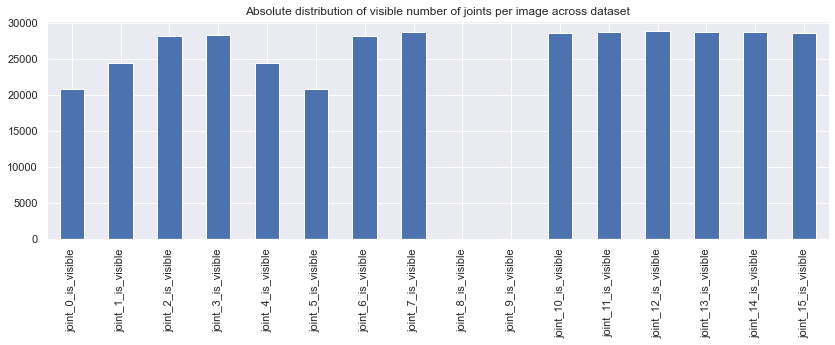

In [23]:
_ = bbox_dataset_df.filter(
    regex="joint_[0-9]*_is_visible"
).notna().sum(axis=0).plot(
    kind="bar",
    figsize=(14, 4),
    title="Absolute distribution of visible number of joints per image across dataset"
)

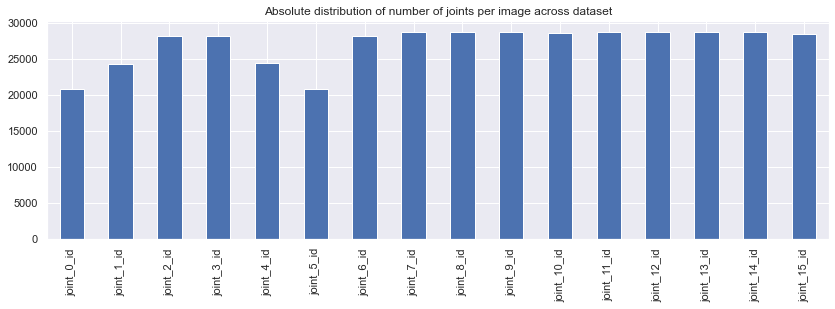

In [24]:
_ = bbox_dataset_df.filter(
    regex="joint_[0-9]*_id"
).notna().astype(int).sum(axis=0).plot(
    kind="bar", 
    figsize=(14, 4),
    title='Absolute distribution of number of joints per image across dataset')

It appears, the 8th and 9th indexed joint have a very low visibility rate.

In [25]:
# Compute Visibility Ratio
pd.DataFrame(
    (
        bbox_dataset_df.filter(
            regex="joint_[0-9]*_is_visible"
        ).clip(upper=1).sum().values / 
        bbox_dataset_df.filter(
            regex="joint_[0-9]*_id"
        ).notna().astype(int).sum().values *100),
    [f'joint_{i}' for i in range(16)], columns=['% of visibility']
)

,% of visibility
joint_0,74.476484
joint_1,79.005343
joint_2,72.997306
joint_3,73.169608
joint_4,79.005094
joint_5,74.533025
joint_6,56.167260
joint_7,57.452745
joint_8,0.006975
joint_9,0.006975


Let's focus now on the statistics of visible joints per image

In [26]:
# For Visible Joints
print("#Joints/Image MEDIAN:",bbox_dataset_df[[f'joint_{i}_is_visible' for i in range(16)]].sum(axis=1).median())
print("#Joints/Image MEAN:",bbox_dataset_df[[f'joint_{i}_is_visible' for i in range(16)]].sum(axis=1).mean())
print("#Joints/Image STD:",bbox_dataset_df[[f'joint_{i}_is_visible' for i in range(16)]].sum(axis=1).std())

#Joints/Image MEDIAN: 10.0
#Joints/Image MEAN: 9.456209644181893
#Joints/Image STD: 3.1274884225125033


In [27]:
# For Joints
print("#Joints/Image MEDIAN:",bbox_dataset_df[[f'joint_{i}_id' for i in range(16)]].notna().astype(int).sum(axis=1).median())
print("#Joints/Image MEAN:",bbox_dataset_df[[f'joint_{i}_id' for i in range(16)]].notna().astype(int).sum(axis=1).mean())
print("#Joints/Image STD:",bbox_dataset_df[[f'joint_{i}_id' for i in range(16)]].notna().astype(int).sum(axis=1).std())

#Joints/Image MEDIAN: 16.0
#Joints/Image MEAN: 14.861072949580986
#Joints/Image STD: 2.2256605383368426


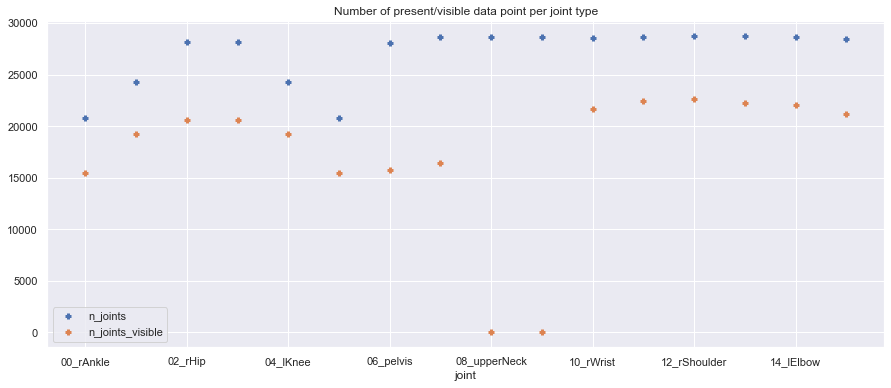

In [28]:
analysis_df = bbox_dataset_df[
    [f'joint_{i}_id' for i in range(16)]
].notna().astype(int).sum(axis=0).reset_index().rename(
    columns={'index':'joint', 0:'n_joints'}
)
analysis_df = analysis_df.assign(
    joint = analysis_df.joint.str.split('_').str[:2].str.join('_').map(dict(zip([f'joint_{i}'for i in range(16)], CFG.dataset.description.joints.names)))
).set_index('joint')

#.plot(linestyle='', figsize=(15, 6), marker='+', )
analysis_visible_df = bbox_dataset_df[
    [f'joint_{i}_is_visible' for i in range(16)]
].sum(axis=0).reset_index().rename(
    columns={'index':'joint', 0:'n_joints_visible'}
)
analysis_visible_df = analysis_visible_df.assign(
    joint = analysis_visible_df.joint.str.split('_').str[:2].str.join('_').map(dict(zip([f'joint_{i}'for i in range(16)], CFG.dataset.description.joints.names)))
).set_index('joint')

analysis_df = analysis_df.merge(analysis_visible_df, on='joint')
_ = analysis_df.plot(title='Number of present/visible data point per joint type',linestyle='', figsize=(15, 6), marker='+', markeredgewidth=3)


From the previous analysis, we observe the `upperNeck` and `topHead` joints have a low visibility rate. We cannot use the visibility information to build our dataset.

In [29]:
bbox_dataset_df = bbox_dataset_df.assign(
    available_joints=bbox_dataset_df.filter(regex="joint_[0-9]*_x").notna().astype(int).sum(axis=1)
)
bbox_dataset_df.filter(['imgidx', 'image','ridx', 'available_joints'])

,imgidx,image,ridx,available_joints
5,4,015601864.jpg,0,16
6,4,015601864.jpg,1,16
7,5,015599452.jpg,0,12
8,5,015599452.jpg,1,12
9,5,015599452.jpg,2,11
...,...,...,...,...
40930,24984,084761779.jpg,0,16
40931,24984,084761779.jpg,1,16
40932,24984,084761779.jpg,2,16
40933,24984,084761779.jpg,3,14


## Generate Input/Output

From the bbox_dataset_df dataset we will use the following data:
- `image`: image name
- `x1`: Person Left bbox coordinate
- `x2`: Person Right bbox coordinate
- `y1`: Person Top bbox coordinate
- `y2`: Person Bootom bbox coordinate
- `joint_<JOINT_ID>_x`: joint JOINT_ID x coordinate
- `joint_<JOINT_ID>_y`: joint JOINT_ID y coordinate

### Numpy Implementation

#### Heatmap Generation

To describe our heatmap generation process we'll try to implement our preprocessing steps with Numpy

In [30]:
sample_df = bbox_dataset_df.query('13 <= available_joints <= 15').sample()
sample_df

,imgidx,image,frame_sec,vididx,is_train,ridx,x1,x2,y1,y2,...,joint_14_is_visible,joint_15_x,joint_15_y,joint_15_id,joint_15_is_visible,video_list,cat_name,act_name,act_id,available_joints
6674,4179,030574396.jpg,10,2514,1,2,246.0,345.0,176.0,300.0,...,1.0,106.0,543.0,15.0,1.0,tL45m_dNvRI,bicycling,"bicycling, mountain",840,14


We plot our sample image

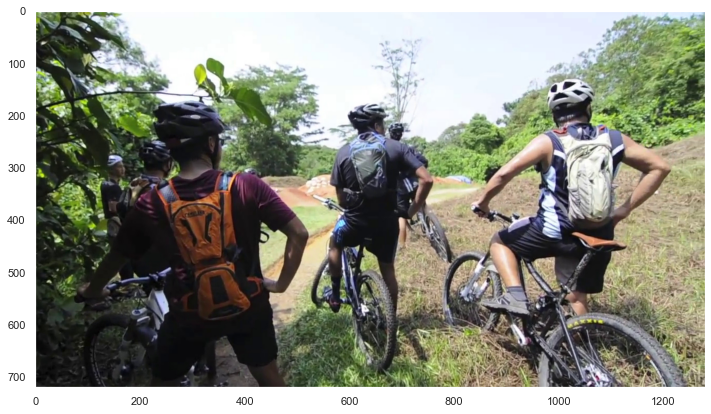

In [31]:
img = imread(os.path.join(ROOT_FOLDER, DATA_FOLDER, IMAGE_FOLDER,sample_df.image.iloc[0]))
plt.figure(figsize=(12,7))
plt.imshow(img)
plt.grid(b=None)

In [32]:
sample_df.filter(regex="joint_[0-9]*_(x|y)")

,joint_0_x,joint_0_y,joint_1_x,joint_1_y,joint_2_x,joint_2_y,joint_3_x,joint_3_y,joint_4_x,joint_4_y,...,joint_11_x,joint_11_y,joint_12_x,joint_12_y,joint_13_x,joint_13_y,joint_14_x,joint_14_y,joint_15_x,joint_15_y
6674,NaN,NaN,450.0,712.0,406.0,553.0,298.0,573.0,249.0,702.0,...,502.0,423.0,404.0,330.0,207.0,377.0,153.0,472.0,106.0,543.0


We generate the first heatmap for the `rWrist`

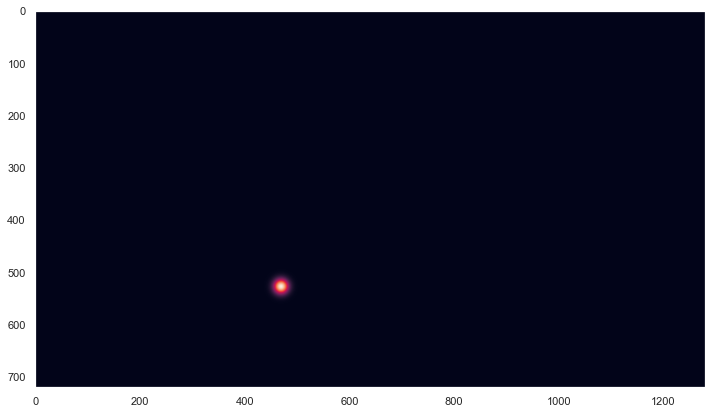

In [33]:
plt.figure(figsize=(12,7))
sample_heatmap = generate_joint_gaussian(img, sample_df.joint_10_x.iloc[0], sample_df.joint_10_y.iloc[0], sx=10, sy=10)
normalized_heatmap = (sample_heatmap / sample_heatmap.max())
plt.imshow(sample_heatmap)
plt.grid(b=None)

By superposing our heatmap to the input image we check if the heatmap is relevant

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


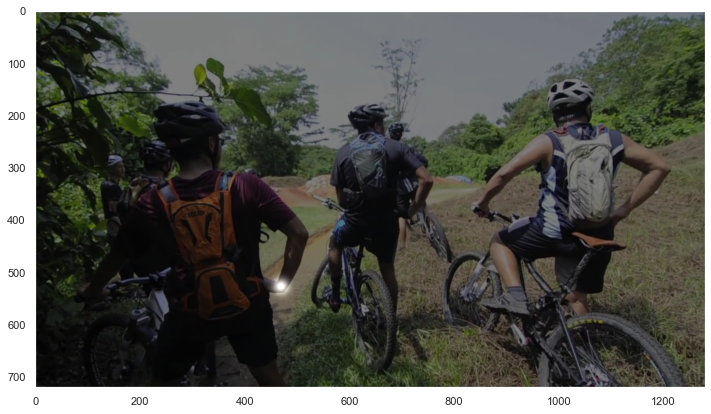

In [34]:
plt.figure(figsize=(12,7))
plt.imshow((np.expand_dims((normalized_heatmap * 255).astype(np.uint8), axis=-1)/255.0 + img/510.0))
plt.grid(b=None)

We are now able to generate heatmaps for single joint. We can appkly this function to all the joint to compute the complete heatmap

In [35]:
# Let's compute the joint dictionnary `sample_joints` (Dict[str, Point(x, y)])
sample_df.filter(regex="joint_[0-9]*_(x|y)").iloc[0]
sample_joints = {f'joint_{k}':{} for k in range(16)}
_ = [sample_joints["_".join(k.split('_')[:-1])].update({k.split('_')[-1]:v})  for k, v in sample_df.filter(regex="joint_[0-9]*_(x|y)").iloc[0].to_dict().items()]
sample_joints

{'joint_0': {'x': nan, 'y': nan},
 'joint_1': {'x': 450.0, 'y': 712.0},
 'joint_2': {'x': 406.0, 'y': 553.0},
 'joint_3': {'x': 298.0, 'y': 573.0},
 'joint_4': {'x': 249.0, 'y': 702.0},
 'joint_5': {'x': nan, 'y': nan},
 'joint_6': {'x': 352.0, 'y': 563.0},
 'joint_7': {'x': 306.0, 'y': 354.0},
 'joint_8': {'x': 301.2217, 'y': 301.2106},
 'joint_9': {'x': 289.7783, 'y': 174.7894},
 'joint_10': {'x': 470.0, 'y': 528.0},
 'joint_11': {'x': 502.0, 'y': 423.0},
 'joint_12': {'x': 404.0, 'y': 330.0},
 'joint_13': {'x': 207.0, 'y': 377.0},
 'joint_14': {'x': 153.0, 'y': 472.0},
 'joint_15': {'x': 106.0, 'y': 543.0}}

We can plot the full heatmap for the person's body

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


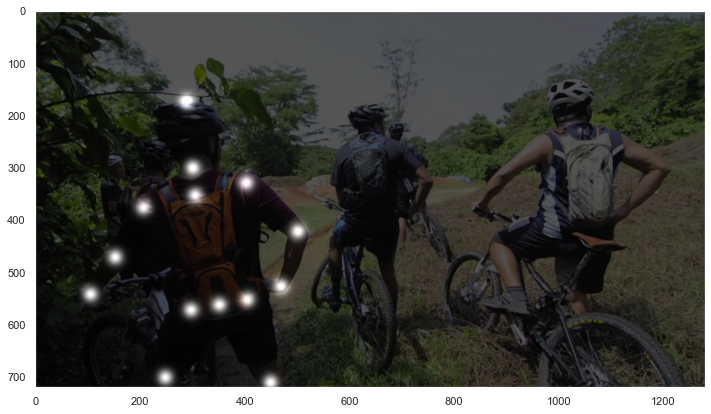

In [36]:
sample_heatmaps = np.stack([generate_joint_gaussian(img, **v, sx=10, sy=10) for k,v in sample_joints.items()])
len(sample_heatmaps)
plot_hVSimg(img, sample_heatmaps, factor=3)

#### Bounding Box Cropping

First of all we list all the joints available for the image and we compute the person bounding box from the extrema

In [37]:
# Get the Available Joints
xs = [v['x'] for j, v in sample_joints.items() if np.isfinite(v['x'])]
ys = [v['y'] for j, v in sample_joints.items() if np.isfinite(v['y'])]

# Get the Min-Max Coordinates
miny, maxy = min(ys),max(ys)
minx, maxx = min(xs),max(xs)

Since we wish to avoid small uncentered person on the image, we preprocess the coordinates before generating heatmaps

In [38]:
# Check Image Lenght
INIT_HEIGHT, INIT_WIDTH = img.shape[:-1]
width, height = maxx-minx, maxy-miny

# Add BBOX Factor
BBOX_FACTOR=0.5 # Add 10% of the Cropped Image
minx = int(max(0, minx-width*BBOX_FACTOR))
miny = int(max(0, miny-height*BBOX_FACTOR))
maxx = int(min(INIT_WIDTH, maxx+width*BBOX_FACTOR))
maxy = int(min(INIT_HEIGHT, maxy+height*BBOX_FACTOR))

# Compute Image Lenght
width, height = maxx-minx, maxy-miny

# Compute Padding
height_padding = max(0, width-height)
width_padding = max(0, height-width)
padding = [[height_padding//2, height_padding//2], [width_padding//2, width_padding//2], [0,0]]

Now we can apply the cropping, padding and resizing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


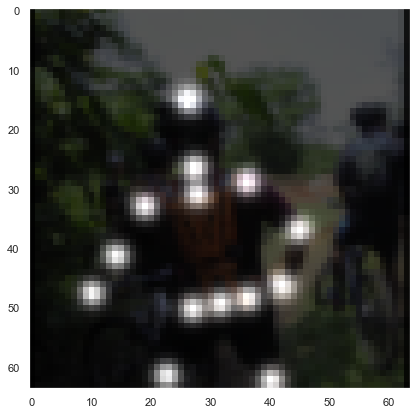

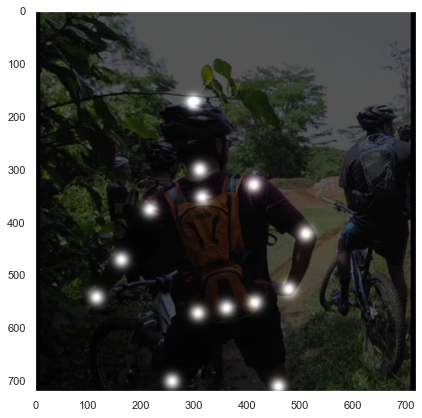

In [39]:
# Padd Image
new_img = np.pad(img[miny:maxy, minx:maxx, :].copy(), padding)

# Update Joints
new_joints = sample_joints.copy()
[new_joints.update({j:{'x': v['x'] - (minx - width_padding//2), 'y': v['y'] - (miny - height_padding//2)}}) for j, v in new_joints.items()]

# Joints reshaped
NEW_SHAPE = 64
joints_reshaped = new_joints.copy()
[joints_reshaped.update({j:{'x': v['x']*NEW_SHAPE / float(max(height, width)), 'y': v['y']*NEW_SHAPE / float(max(height, width))}}) for j, v in joints_reshaped.items()]

# Reshape Image
reshaped_img = (resize(new_img, (NEW_SHAPE, NEW_SHAPE)) * 255).astype(np.int)
reshaped_heatmap = np.stack([generate_joint_gaussian(reshaped_img, **v, sx=1.5, sy=1.5) for k,v in joints_reshaped.items()])
plot_hVSimg(reshaped_img.astype(np.int), reshaped_heatmap, factor=3)
# Plot
sample_heatmaps = np.stack([generate_joint_gaussian(new_img, **v, sx=10, sy=10) for k,v in new_joints.items()])
plot_hVSimg(new_img, sample_heatmaps, factor=3)

We can look at the preprocessing performance, on the first run we compute the heatmaps on the final output size, on the second cell we generate the heatmap after the padding to resize it after.

In [40]:
%%timeit
for i in range(10):
    _ = np.stack([generate_joint_gaussian(reshaped_img, **v, sx=1.5, sy=1.5) for k,v in joints_reshaped.items()])

25.4 ms ± 726 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
%%timeit
for i in range(10):
    _ = np.stack([generate_joint_gaussian(new_img, **v, sx=10, sy=10) for k,v in new_joints.items()])

1.42 s ± 38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Tensorflow Implementation

#### Loading & Heatmap generating functions

In [42]:
# Generates Input Data
filenames = (os.path.join(ROOT_FOLDER, DATA_FOLDER, IMAGE_FOLDER) + '/' + bbox_dataset_df.filter(regex="image")).image.tolist()
coordinates = bbox_dataset_df.filter(regex="joint_[0-9]*_(x|y)").values.reshape((-1, 16, 2))

In [ ]:
@tf.function
def tf_generate_heatmap(images, coords):
    heatmaps = tf_heatmaps(coords, images)
    return images, heatmaps

In [62]:
# Create TF Dataset
dataset = tf.data.Dataset.from_tensor_slices(
    (filenames, coordinates)
).map(
    tf_load_images
).map(
    lambda x, y: tf_compute_coordinates(x, y, 0.5, 64)
)#.map(
 #   tf_generate_heatmap
#)

In [63]:
for tfsample in dataset.take(5):
    pass

In [64]:
tfsample[1]

<tf.Tensor: shape=(16, 2), dtype=float64, numpy=
array([[        nan,         nan],
       [        nan,         nan],
       [33.06666667, 47.73333333],
       [19.37777778, 47.64444444],
       [        nan,         nan],
       [        nan,         nan],
       [26.22222222, 47.73333333],
       [24.26666667, 22.31111111],
       [23.73333333, 19.37777778],
       [20.71111111,  2.75555556],
       [32.35555556, 33.15555556],
       [39.2       , 40.53333333],
       [33.42222222, 22.31111111],
       [15.11111111, 22.31111111],
       [15.11111111, 37.6       ],
       [        nan,         nan]])>

In [59]:
tf.reduce_all(tf.math.is_finite(tfsample[1]), axis=1)

<tf.Tensor: shape=(16,), dtype=bool, numpy=
array([False, False,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False])>

<tf.Tensor: shape=(16, 64, 64), dtype=float64, numpy=
array([[[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        ...,
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000]],

       [[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [0.00000000e+000, 0.00000000e+000, 0.0000

In [69]:
tf.unstack(tfsample[1], axis=0)

[<tf.Tensor: shape=(2,), dtype=float64, numpy=array([nan, nan])>,
 <tf.Tensor: shape=(2,), dtype=float64, numpy=array([nan, nan])>,
 <tf.Tensor: shape=(2,), dtype=float64, numpy=array([33.06666667, 47.73333333])>,
 <tf.Tensor: shape=(2,), dtype=float64, numpy=array([19.37777778, 47.64444444])>,
 <tf.Tensor: shape=(2,), dtype=float64, numpy=array([nan, nan])>,
 <tf.Tensor: shape=(2,), dtype=float64, numpy=array([nan, nan])>,
 <tf.Tensor: shape=(2,), dtype=float64, numpy=array([26.22222222, 47.73333333])>,
 <tf.Tensor: shape=(2,), dtype=float64, numpy=array([24.26666667, 22.31111111])>,
 <tf.Tensor: shape=(2,), dtype=float64, numpy=array([23.73333333, 19.37777778])>,
 <tf.Tensor: shape=(2,), dtype=float64, numpy=array([20.71111111,  2.75555556])>,
 <tf.Tensor: shape=(2,), dtype=float64, numpy=array([32.35555556, 33.15555556])>,
 <tf.Tensor: shape=(2,), dtype=float64, numpy=array([39.2       , 40.53333333])>,
 <tf.Tensor: shape=(2,), dtype=float64, numpy=array([33.42222222, 22.31111111])>

In [68]:
tf.map_fn(
    lambda x: tf_bivariate_normal_pdf(
        64, 64, 
        *x, 
        sx=10.0, 
        sy=10.0
    ),
    tf.unstack(tfsample[1], axis=0)
)

TypeError: in user code:

    <ipython-input-68-f8ae448efca4>:2 None  *
        lambda x: tf_bivariate_normal_pdf(
    /Users/walid/.local/share/virtualenvs/hourglasstensorlfow-kuwAf2CD/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py:780 __call__  **
        result = self._call(*args, **kwds)
    /Users/walid/.local/share/virtualenvs/hourglasstensorlfow-kuwAf2CD/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py:823 _call
        self._initialize(args, kwds, add_initializers_to=initializers)
    /Users/walid/.local/share/virtualenvs/hourglasstensorlfow-kuwAf2CD/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py:696 _initialize
        self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
    /Users/walid/.local/share/virtualenvs/hourglasstensorlfow-kuwAf2CD/lib/python3.8/site-packages/tensorflow/python/eager/function.py:2855 _get_concrete_function_internal_garbage_collected
        graph_function, _, _ = self._maybe_define_function(args, kwargs)
    /Users/walid/.local/share/virtualenvs/hourglasstensorlfow-kuwAf2CD/lib/python3.8/site-packages/tensorflow/python/eager/function.py:3170 _maybe_define_function
        args, kwargs = self._function_spec.canonicalize_function_inputs(
    /Users/walid/.local/share/virtualenvs/hourglasstensorlfow-kuwAf2CD/lib/python3.8/site-packages/tensorflow/python/eager/function.py:2592 canonicalize_function_inputs
        raise TypeError("{} got two values for argument '{}'".format(

    TypeError: tf_bivariate_normal_pdf(height, width, mx, my, sx, sy) got two values for argument 'sx'


In [ ]:
# Create TF Dataset
dataset = tf.data.Dataset.from_tensor_slices(
    (filenames, coordinates)
).map(tf_parse_dataset).map(tf_preprocess)
dataset

In [ ]:
INDEX = 5
for tfsample in dataset.take(INDEX):
    pass
plot_hVSimg(
    tfsample[0].numpy(), 
    tf.transpose(tf.image.resize(tfsample[1], [256, 256]), [2, 0, 1]).numpy(),
    factor=2)

# Conclusion

As described in this notebook, we created a preprocessing pipeline to generate input and output data from raw images and the Dataset created in our first notebook.

We also replicated our Numpy workflow with Tensorflow. The machine used for this notebook has no GPU, thus explaining the high processing time for a single image with TF.

**NB:**

We can provide an obvious criticism about our processing. As shown in the image above, we use images with multiple person as **input** and a single person ground truth as **output**. We can evidently assume this processing will bias the model by confusing it's learning.

    e.g:
        Let's define an image $I(HxW), with $P person with joint coordinates (n in [0, P-1] -> x_i:n, y_i:n)
        For $I our model might output the correct body joint for a person X, our ground truth being for person Y.
        In this case, our model's loss function will indicate to the model it was wrong even if the prediction was perfect.
        
We can define more suitable preprocessing pipelines.

**Exemple #1: Single Person Input**
- Get an Image I
- For person p on P people
    - Get p bounding box
    - Crop p
    - Offset the joints with the top-left bbox corner
    - Generate the heatmap on the cropped image
    - Apply zero-padding to have a square shaped image
    - Resize to the desired input size
    - Add the resulting image to your dataset

**Exemple #2: Multiple Person Input**
- Get an Image I
- Generate the Heatmap for each person and sum it (1 layers per body joint)
- Apply passing and Resize to have a squared image

This second workflow slighty modifies the task. The model will not be a Human Pose Estimator but rather a Body Joint detector. A second model should be in charge of reconciliating the infered body joints for a single person (Possible with Graph Model and raw programmatic logic)



